In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

/Users/mananmehta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# reading captions and creating a dictionary 

In [2]:
with open('/Users/mananmehta/Desktop/flickr8k/Flickr_Data/Flickr_TextData/Flickr8k.token.txt') as f:
    captions = f.read()
       
        

In [3]:
captions = captions.split('\n')
captions = captions[:-1]

In [4]:
descriptions = {}
for line in captions:
    sent = line.split('\t')
    img_name = sent[0].split(".")[0]
    cap = sent[1]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
       
    descriptions[img_name].append(cap)
        
    
    

In [6]:
print(descriptions)

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

# text cleaning of captions:
- convert all snetences to lower case
- remove all numbers and punctuation
- remove words of len 1

In [6]:
def text_cleaning(sent):
    sent = sent.lower()
    sent = re.sub("[^a-zA-Z]+"," ",sent)
    sent = sent.split()
    
    sent = [w for w in sent if len(w)>1]
    sent = " ".join(sent)
    return sent

In [7]:
text_cleaning("I have a email that is abc!!!@xyz.com ")

'have email that is abc xyz com'

In [8]:
for key in descriptions.keys():
    for i in range(len(descriptions[key])):
        descriptions[key][i] = text_cleaning(descriptions[key][i])

In [9]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
vocab = set()
for key in descriptions.keys():
    for cap in descriptions[key]:
        vocab.update([w for w in cap.split()])

In [11]:
len(vocab)

8424

In [12]:
total_words = []
for key in descriptions.keys():
    [total_words.append(w) for cap in descriptions[key] for w in cap.split()]

In [13]:
len(total_words)

373837

In [14]:
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)

In [15]:
len(freq_cnt)

8424

# taking threshold 8

In [16]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key = lambda x:x[1])
threshold = 8
vocab_words = [word[0] for word in sorted_freq_cnt if word[1] > threshold ]

In [17]:
len(vocab_words)

2110

# creating word_to_idx and idx_to_word dictionaries

In [18]:
word_to_idx = {}
idx_to_word = {}

for ix,word in enumerate(vocab_words):
    word_to_idx[word] = ix + 1
    idx_to_word[ix+1] = word 


In [19]:
word_to_idx['startseq'] = 2111
word_to_idx['endseq'] = 2112

idx_to_word[2111] = 'startseq'
idx_to_word[2112] = 'endseq'

In [20]:
vocab_size = len(word_to_idx) + 1

# now lets work on embeddings
- creating an embedding matrix

In [21]:
embeddings_dict = {}
with open('/Users/mananmehta/Desktop/ml/PRACTICE_HOME/glove.6B.50d.txt') as f:
    for line in f:
        word = line.split()[0]
        embeddings_dict[word] = np.array(line.split()[1:],dtype = 'float')

In [22]:
embeddings_dict['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

# now lets create an embeddings matrix

In [23]:
embedding_matrix = np.zeros((vocab_size,50))
for word,idx in word_to_idx.items() :
    if embeddings_dict.get(word) is not None:
        embedding_matrix[idx] = embeddings_dict[word]
       

In [24]:
embedding_matrix[2] # embedding of 'the' look above

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [25]:
print(embedding_matrix.shape)

(2113, 50)


# now we will load training and test files 

### TRAIN

In [26]:
with open("/Users/mananmehta/Desktop/flickr8k/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt") as f:
    train = f.read()

In [27]:
train = train.split('\n')
train = train[:-1]

In [28]:
train_descriptions = {}
for img_name in train:
    img_name = img_name.split('.')[0]
    train_descriptions[img_name] = []
    for cap in descriptions[img_name]:
        cap_to_append = 'startseq ' + cap + ' endseq'
        train_descriptions[img_name].append(cap_to_append)

In [29]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [30]:
maxlen = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxlen = max(maxlen,len(cap.split()))
print(maxlen)

35


### TEST

In [31]:
with open("/Users/mananmehta/Desktop/flickr8k/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt") as f:
    test = f.read()

In [32]:
test = test.split('\n')
test = test[:-1]

In [33]:
test_descriptions = {}
for img_name in test:
    img_name = img_name.split('.')[0]
    test_descriptions[img_name] = []
    for cap in descriptions[img_name]:
        cap_to_append = 'startseq ' + cap + ' endseq'
        test_descriptions[img_name].append(cap_to_append)

In [34]:
test_descriptions['1258913059_07c613f7ff']

['startseq couple of people sit outdoors at table with an umbrella and talk endseq',
 'startseq three people are sitting at an outside picnic bench with an umbrella endseq',
 'startseq three people sit at an outdoor cafe endseq',
 'startseq three people sit at an outdoor table in front of building painted like the union jack endseq',
 'startseq three people sit at picnic table outside of building painted like union jack endseq']

(281, 500, 3)


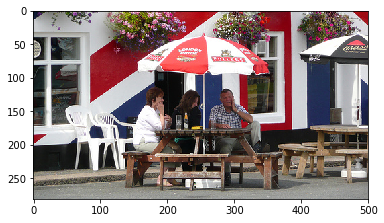

In [35]:
img = image.load_img('/Users/mananmehta/Desktop/flickr8k/Flickr_Data/Images/'+'1258913059_07c613f7ff.jpg')
img = image.img_to_array(img)

plt.imshow(img/255)
print(img.shape)

# Now we have done text preprocessing 
- we will do image preprocessing

In [36]:
res_model = ResNet50(weights = 'imagenet',input_shape = (224,224,3))
res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [37]:
new_res_model = Model(input = res_model.input,output = res_model.layers[-2].output)

/Users/mananmehta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  """Entry point for launching an IPython kernel.


In [38]:
new_res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [39]:
IMG_PATH = '/Users/mananmehta/Desktop/flickr8k/Flickr_Data/Images/'

In [40]:
def preprocess_img(img):
    img = image.load_img(img,target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis = 0)
    img = preprocess_input(img)
    return img

In [41]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = new_res_model.predict(img)
    feature_vector = feature_vector.reshape((2048,))
    return feature_vector

# now we will create a dictionary of image_name and its corresponding feature vectors
- only doing for 200 examples
- because pickle file is already stored in disk

In [110]:
start = time()
encode_images = {}
n = 1
for ix,img_name in enumerate(train):
    encode_images[img_name] = encode_img(IMG_PATH+img_name)
    if ix%100 == 0:
        print('encoding in progess , time step %d'%ix)
    
    n += 1
    if n==100:
        break
  
end_t = time()
print("Total time taken ", start - end_t)

encoding in progess , time step 0
encoding in progess , time step 100
Total time taken  -125.00492215156555


In [42]:
with open('./encoded_training_data','rb') as f:
    encoded_images = pickle.load(f)

In [43]:
encoded_images['2903617548_d3e38d7f88.jpg']

array([0.        , 0.00240234, 0.07777373, ..., 0.32226396, 0.33870834,
       0.82707757], dtype=float32)

# creating a custom data generator

In [45]:
vocab_size

2113

In [44]:
def data_loader(train_descriptions,encoded_images,max_len ,batchsize,word_to_idx):
    X1,X2,Y = [],[],[]
    n = 0
    while True:
        for key in train_descriptions.keys():
            n = n+1
            photo = encoded_images[key+'.jpg']
            
            for cap in train_descriptions[key]:
                seq = [word_to_idx[w] for w in cap.split() if w in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]

                    xi = pad_sequences([xi],maxlen=max_len,value = 0,padding = 'post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)

                    
            if n== batchsize:
                yield [[np.array(X1),np.array(X2)],np.array(Y)]
                X1,X2,Y = [],[],[]
                n = 0

In [45]:
input_img_features = Input(shape=(2048,))
img_feature1 = Dropout(0.3)(input_img_features)
img_feature2 = Dense(256,activation='relu')(img_feature1)

In [46]:
input_cap_features = Input(shape = (maxlen,))
cap_features1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_cap_features)
cap_features2 = Dropout(0.3)(cap_features1)
cap_features3 = LSTM(256)(cap_features2)


In [47]:
decoder_1 = add([img_feature2,cap_features3])
decoder_2 = Dense(256,activation='relu')(decoder_1)
output = Dense(vocab_size,activation='softmax')(decoder_2)

model = Model(inputs = [input_img_features,input_cap_features],outputs = output)

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       105650      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [49]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [50]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [51]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [52]:
for i in range(epochs):
    generator = data_loader(train_descriptions,encoded_images,maxlen,batch_size,word_to_idx)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose = 1)
    model.save_weights('./model_weights/model_'+ str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 806s 403ms/step - loss: 4.3439
Epoch 1/1
2000/2000 [==============================] - 799s 400ms/step - loss: 3.6056
Epoch 1/1
2000/2000 [==============================] - 799s 399ms/step - loss: 3.3399
Epoch 1/1
2000/2000 [==============================] - 815s 408ms/step - loss: 3.1787
Epoch 1/1
2000/2000 [==============================] - 897s 448ms/step - loss: 3.0624
Epoch 1/1
2000/2000 [==============================] - 799s 399ms/step - loss: 2.9731
Epoch 1/1
2000/2000 [==============================] - 805s 403ms/step - loss: 2.9027
Epoch 1/1
2000/2000 [==============================] - 805s 402ms/step - loss: 2.8427
Epoch 1/1
2000/2000 [==============================] - 804s 402ms/step - loss: 2.7966
Epoch 1/1
2000/2000 [==============================] - 804s 402ms/step - loss: 2.7548


In [53]:
maxlen

35

In [54]:
model.load_weights("./model_weights/model_9.h5")


In [55]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(maxlen):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=maxlen, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

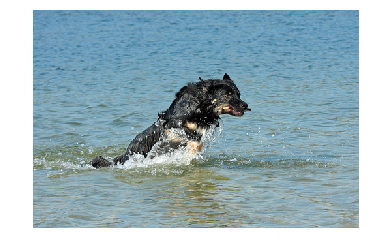

black dog running through water


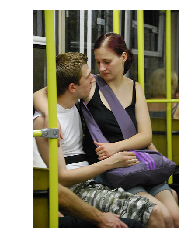

boy in black shirt is playing with his feet on the phone


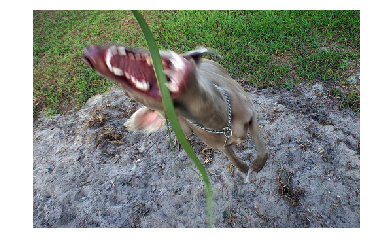

brown dog is running through field


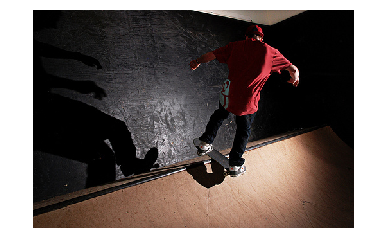

skateboarder is doing stunt on skateboard


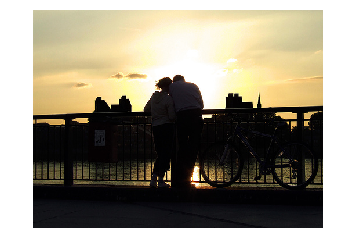

man in white shirt is sitting on bench near the ocean


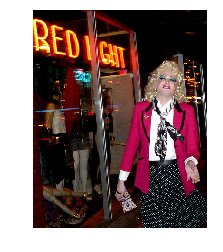

man in black shirt and black shirt is standing in front of crowd


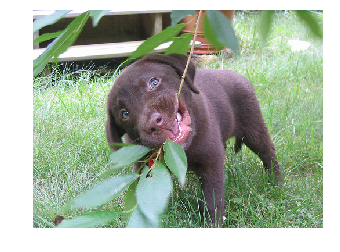

black dog is running through the grass


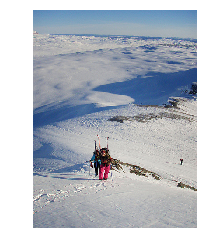

two people are walking along snowy mountain


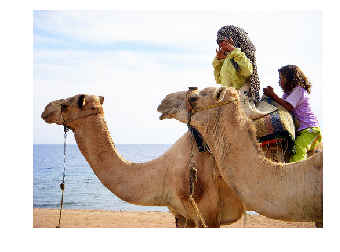

two dogs are playing in the sand


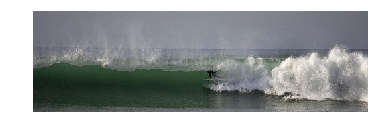

surfer in the middle of crashing


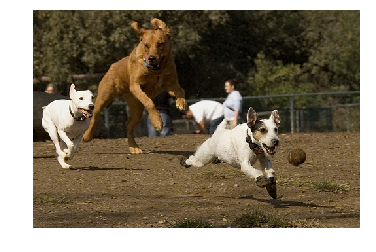

two dogs are running on dirt track


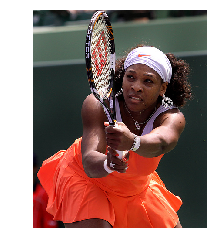

woman in green shirt and white shirt is wearing helmet


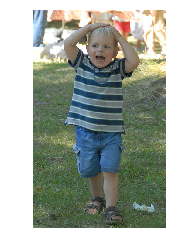

little girl in white dress is holding up her head


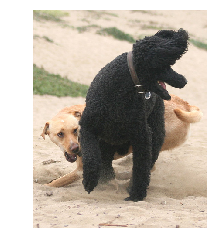

dog running on beach


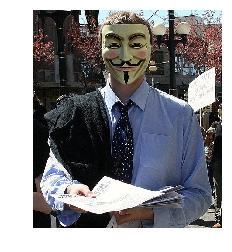

man in black shirt and black cap is standing in front of people


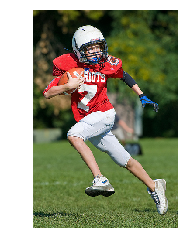

the boy in the blue shirt is playing soccer


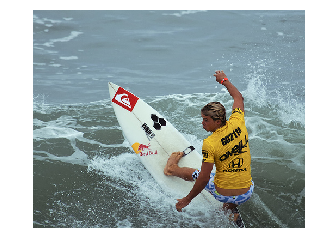

surfer in wetsuit is riding wave


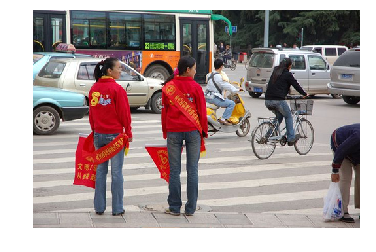

man in red shirt is standing in front of traffic


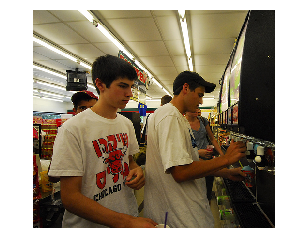

woman in black shirt is standing in front of crowd


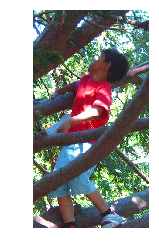

girl in red shirt is jumping in the air


In [57]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoded_images.keys())[rn]
    photo = encoded_images[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)